In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from keras.datasets import cifar10

In [3]:
dataset = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = dataset

170508288/170498071 [==============================] - 4s 0us/step


In [22]:
classes=["Airplane","Automobile","Bird", "Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
y_train= y_train.reshape(-1,)
y_test= y_test.reshape(-1,)
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [5]:
def plot_sample(x,y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(x[index])
  plt.xlabel(classes[y[index]]) 

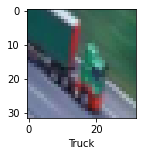

In [6]:
plot_sample(x_train, y_train, 50)

In [7]:
# Normalize the data and converting to float 32 
X_train= x_train.astype('float32') / 255.0
X_test= x_test.astype('float32') / 255.0

In [8]:
def res_identity(x, filters):
  x_skip = x
  f1, f2 = filters

  #First Block
  x = tf.keras.layers.Conv2D(f1, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #Second Block
  x = tf.keras.layers.Conv2D(f1, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #Third Block
  x = tf.keras.layers.Conv2D(f2, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #Add Residue
  x = tf.keras.layers.Add()([x, x_skip])
  x = tf.keras.layers.Activation('relu')(x)

  return x

In [9]:
def res_conv(x, s, filters):
  x_skip = x;
  f1, f2 = filters;

  #First Block
  x = tf.keras.layers.Conv2D(f1, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #Second Block
  x = tf.keras.layers.Conv2D(f1, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  #Third Block
  x = tf.keras.layers.Conv2D(f2, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  #Bottle Neck Layer
  x_skip = tf.keras.layers.Conv2D(f2, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x_skip)
  x_skip = tf.keras.layers.BatchNormalization()(x_skip)
  #Add Residue
  x = tf.keras.layers.Add()([x, x_skip])
  x = tf.keras.layers.Activation('relu')(x)

  return x

In [10]:
shape = x_train.shape[1], x_train.shape[2], x_train.shape[3]
print(shape)

(32, 32, 3)


In [11]:

def resnet50(shape, classes=10):
  x_input = tf.keras.layers.Input(shape)
  x = tf.keras.layers.ZeroPadding2D(padding=(3,3))(x_input)
  #1st Stage with Maxpooling
  x = tf.keras.layers.Conv2D(64, kernel_size=(7,7), strides=(2,2)) (x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
  #2nd Stage
  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  #3rd Stage
  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  #4th Stage
  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  #5th Stage
  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  x = tf.keras.layers.AveragePooling2D(strides=(2,2), padding='same')(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)
  #Define the Model
  model = tf.keras.models.Model(inputs=x_input, outputs=x, name='ResNet50')

  return model

In [12]:
model = resnet50(shape)
print(model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

In [13]:
model.compile(loss= 'sparse_categorical_crossentropy',
              optimizer= 'Adam',
              metrics=['accuracy'])

In [14]:
model.fit(x_train, y_train, batch_size=64, epochs=160)

Epoch 1/160
782/782 [==============================] - 55s 49ms/step - loss: 14.0693 - accuracy: 0.3767
Epoch 2/160
782/782 [==============================] - 38s 49ms/step - loss: 7.3226 - accuracy: 0.4121
Epoch 3/160
782/782 [==============================] - 39s 49ms/step - loss: 5.7804 - accuracy: 0.3225
Epoch 4/160
782/782 [==============================] - 39s 49ms/step - loss: 4.5346 - accuracy: 0.3542
Epoch 5/160
782/782 [==============================] - 39s 50ms/step - loss: 3.9773 - accuracy: 0.3746
Epoch 6/160
782/782 [==============================] - 38s 49ms/step - loss: 3.7681 - accuracy: 0.3851
Epoch 7/160
782/782 [==============================] - 38s 49ms/step - loss: 3.6622 - accuracy: 0.4012
Epoch 8/160
782/782 [==============================] - 38s 49ms/step - loss: 3.0649 - accuracy: 0.4283
Epoch 9/160
782/782 [==============================] - 38s 49ms/step - loss: 2.6958 - accuracy: 0.4586
Epoch 10/160
782/782 [==============================] - 38s 49ms/step - 

In [16]:
model.evaluate(x_test, y_test, batch_size=32)

313/313 [==============================] - 5s 15ms/step - loss: 1.3573 - accuracy: 0.7220


[1.3573037385940552, 0.722000002861023]

In [17]:
y_pred = model.predict(x_test)

In [18]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[3, 1, 8, 8, 4]

In [19]:
y_test[:5]

array([3, 8, 8, 0, 6], dtype=uint8)

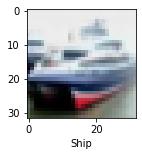

In [20]:
plot_sample(x_test, y_test,1)

In [23]:
classes[y_classes[1]]

'Automobile'

In [24]:
model.save_weights('ResNet50_weights')